In [1]:
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.keras.api import keras

from hpcscripts.sharedutils.trainingutils import LoadModel, SetLowTFVerbose, MakeSinglePrediction, CreateWindowGenerator
from hpcscripts.sharedutils.nomalization import DF_Nomalize, denorm
from hpcscripts.sharedutils.modelutils import SelectModelPrompt
from hpcscripts.option import pathhandler as ph
from hpcscripts.option import globalparams as G_PARAMS

2022-06-22 00:23:50.322505: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 00:23:50.389462: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-06-22 00:23:50.389488: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-06-22 00:23:50.390425: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [2]:
# Get Training Data to calculate norm param
train_file = os.path.join(ph.GetProcessedPath("Combined"), "Train_set.csv")
train_data, NORM_PARAM = DF_Nomalize(pd.read_csv(train_file))

# Make TensorFlow Quiet
SetLowTFVerbose()

# rad2deg
rad2deg = 180 / math.pi

labels = G_PARAMS.SEQUENTIAL_LABELS

In [3]:
def get_file_list():
    train_dir = ph.GetProcessedPath("Selected")
    test_dir  = ph.GetProcessedPath("Test")

    train_list = os.listdir(train_dir)
    test_list  = os.listdir(test_dir)

    for i, test_file in enumerate (test_list):
        train_list.remove(test_file)
        test_list[i] = os.path.join(test_dir, test_file)

    for i, train_file in enumerate (train_list):
        train_list[i] = os.path.join(train_dir, train_file)

    print ("Files found: ")
    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    # Slicing
    print ("\nAfter Slicing: ")
    # train_list = train_list[:3]
    # test_list  = test_list[:3]

    print ("\tTrain count: {}".format(len(train_list)))
    print ("\tTest count : {}".format(len(test_list)))

    return train_list, test_list

In [4]:
def Predict(filename: str, model, window, NORM_PARAM=NORM_PARAM):
    prediction_dict = {}
    file_path = os.path.join (ph.GetProcessedPath("Test"), filename)

    test_df, predictions = MakeSinglePrediction(file_path, model, window)

    for i, label in enumerate(labels):
        z, s = NORM_PARAM[label]
        zt,st= NORM_PARAM["time_s"]

        denormed_time  = denorm(test_df["time_s"].to_numpy(), zt, st)
        denormed_label = denorm(test_df[label], z, s)
        denormed_pred  = denorm(predictions[:, i], z, s)

        if (label.endswith("rad")):
            denormed_pred = denormed_pred * rad2deg
            denormed_label= denormed_label* rad2deg

        prediction_dict[label] = (denormed_label, denormed_pred)
    
    return denormed_time, prediction_dict

def ShowPrediction(filename: str, model, window, NORM_PARAM=NORM_PARAM):
    denormed_time, prediction_dict = Predict(filename, model, window, NORM_PARAM)

    for i, label in enumerate(labels):
        denormed_label, denormed_pred = prediction_dict[label]

        plt.plot(denormed_time, denormed_label)
        plt.plot(denormed_time, denormed_pred)

        print ("timespan: {}".format(denormed_time[-1] - denormed_time[0]))
        print ("mae: {}".format(keras.metrics.mean_absolute_error(denormed_label, denormed_pred)))

        plt.legend(["real", "prediction"])
        plt.xlabel(label.removesuffix("rad")+"deg" if label.endswith("rad") else label)
        plt.show()

## Importing Model

In [5]:
model_dir = ph.GetModelsPath()
model_dir = SelectModelPrompt(model_dir)

print ()
model, model_history, modelsmeta = LoadModel(model_dir)

G_PARAMS.SetParams(modelsmeta['param'])

epochs = [a+1 for a in range(len(model_history['loss']))]
print ("\nmodel_id: {}".format(modelsmeta['model_id']))
print ("model_history keys: {}".format(model_history.keys()))
print ("modelsmeta: {}".format(modelsmeta))

Found 1 models inside /home/ikhwansh/Datas/Cool Yeah/TeA/HPC_Scripts/Data/Models:
index    Model-name
  [0].   ANN 2022-06-22 00:22:07
You selected model ANN 2022-06-22 00:22:07

model loaded
model history loaded
model metadata loaded
model_id: default
model_history keys: dict_keys(['loss', 'mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_mean_squared_error', 'val_mean_absolute_error'])
modelsmeta: {'model_id': 'default', 'param': (1, 1, 0, None, None, None, None)}


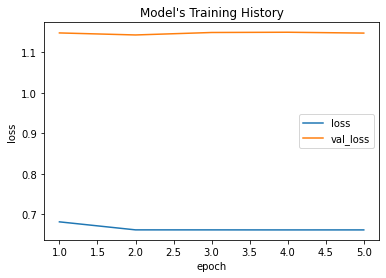

In [6]:
metric = 'loss'
plt.plot(epochs, model_history[metric])
plt.plot(epochs, model_history['val_{}'.format(metric)])

plt.xlabel("epoch")
plt.ylabel(metric)
plt.title("Model's Training History")
plt.legend(['loss', 'val_{}'.format(metric)])
plt.show()

In [7]:
_z, _s = NORM_PARAM['elv_l_rad']
last_val_MAE = model_history['val_mean_absolute_error'][-1]

print ("denormed MAE: {}".format(denorm(last_val_MAE, _z, _s)))
print ("denormed MAE: {}".format(denorm(0.0000, _z, _s)))

elv_MAE = denorm(last_val_MAE, _z, _s)-denorm(0.0000, _z, _s)
elv_MAE = elv_MAE*180/math.pi 
print ("MAE: {} deg".format(elv_MAE))


denormed MAE: -0.05577192526755009
denormed MAE: -0.08058942777347788
MAE: 1.421938151645007 deg


## Making Few Predictions

In [8]:
train_list, test_list = get_file_list()

pred_window = CreateWindowGenerator(
                    train_list=test_list,
                    test_list=None, eval_list=None,
                    norm_param=NORM_PARAM
                )

Files found: 
	Train count: 352
	Test count : 61

After Slicing: 
	Train count: 352
	Test count : 61


In [9]:
filename = test_list[0]
os.path.basename(filename)

'flight_28936.csv'

2022-06-22 00:24:01.837986: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


timespan: 317.0
mae: 2.501063585281372


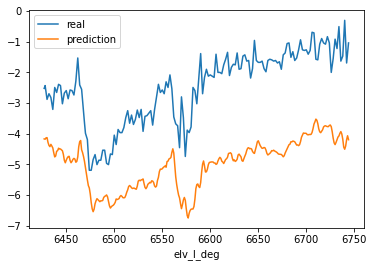

timespan: 317.0
mae: 4.211067199707031


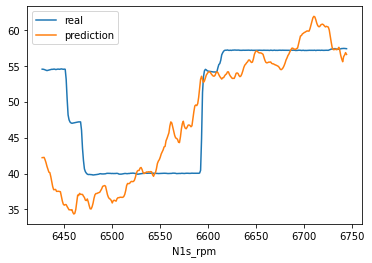

In [10]:
ShowPrediction( 
            "flight_10301.csv",
            model=model,
            window=pred_window
        )

## R2 Results

In [11]:
# Check r2 results
r2csv_path = os.path.join(model_dir, "r2.csv")
if not os.path.exists(r2csv_path):
    exit()

r2_df = pd.read_csv(r2csv_path)

r2_df.describe()
#r2_df.head()

,r2_elv_l_rad,mae_elv_l_rad,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
count,61.000000,61.000000,61.000000,61.000000,61.000000,61.000000
mean,-6.158329,0.025527,0.001245,-0.041911,6.175976,64.685470
std,18.269711,0.022369,0.002487,2.300831,1.799908,36.485568
min,-105.453382,0.005422,0.000049,-17.025091,3.581532,21.802166
25%,-3.455826,0.010476,0.000181,0.202029,4.987492,43.650913
50%,-0.676236,0.018030,0.000393,0.453833,5.911397,58.607834
75%,0.336639,0.033406,0.001277,0.591691,7.028371,73.172485
max,0.745794,0.115777,0.013481,0.780954,11.881667,206.094391


In [12]:
r2_df.nlargest(8, columns=["r2_elv_l_rad"])

,filename,r2_elv_l_rad,mae_elv_l_rad,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
38,flight_17701.csv,0.745794,0.006721,0.000095,-0.164285,6.378942,52.442654
54,flight_20048.csv,0.734986,0.009892,0.000137,0.700296,4.963148,50.228104
56,flight_34901.csv,0.731609,0.005422,0.000049,0.202029,7.218263,102.402451
12,flight_19223.csv,0.663506,0.007339,0.000094,0.755410,4.151063,31.788681
49,flight_31872.csv,0.651754,0.009517,0.000148,0.231536,4.758092,46.812908
13,flight_31626.csv,0.569937,0.011135,0.000189,-1.304464,6.969045,71.568192
6,flight_40083.csv,0.495036,0.009926,0.000158,0.497675,6.053151,66.052299
20,flight_31632.csv,0.481853,0.016272,0.000354,0.348112,5.404594,43.650913


In [13]:
# r2_df.loc[r2_df.iloc[:, 1] < 0]
r2_df.nsmallest(10, columns=["r2_elv_l_rad"])

,filename,r2_elv_l_rad,mae_elv_l_rad,mse_elv_l_rad,r2_N1s_rpm,mae_N1s_rpm,mse_N1s_rpm
10,flight_21884.csv,-105.453382,0.115777,0.013481,0.265023,5.092626,54.731739
55,flight_22498.csv,-79.394642,0.114063,0.013153,0.440275,8.524954,89.457291
19,flight_40945.csv,-53.150545,0.081779,0.006842,-1.253162,10.835844,151.711594
30,flight_16365.csv,-32.134908,0.057501,0.003364,-0.264853,5.181433,33.831802
18,flight_21056.csv,-21.956583,0.054794,0.003106,0.373357,5.740643,62.517586
28,flight_24058.csv,-13.986052,0.043360,0.001944,0.555610,7.347394,71.379547
60,flight_15032.csv,-10.434895,0.039925,0.001646,0.676351,4.930556,42.779163
25,flight_32637.csv,-6.742720,0.039899,0.001786,0.516256,6.788353,73.899139
52,flight_39366.csv,-6.547072,0.037557,0.001464,-1.692792,3.661711,28.900446
14,flight_11823.csv,-5.702885,0.029279,0.001046,0.103063,7.197854,65.963882


filename: flight_33369.csv
timespan: 259.0
mae: 0.31433653831481934


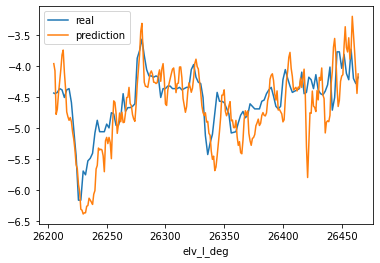

timespan: 259.0
mae: 5.145312309265137


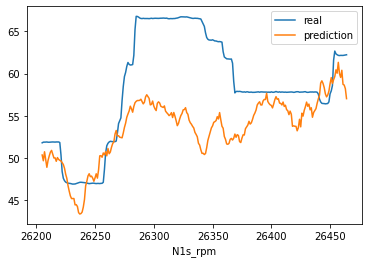

In [14]:
filename_to_predict = "flight_33369.csv"
print ("filename: {}".format(filename_to_predict))
ShowPrediction(filename_to_predict, model, window=pred_window)

min: 201.0
max: 428.0
avg: 316.8196721311475


(array([3., 0., 0., 0., 0., 3., 1., 2., 4., 3., 5., 1., 1., 1., 3., 2., 7.,
        2., 2., 3., 1., 4., 5., 2., 0., 2., 3., 0., 0., 1.]),
 array([201.        , 208.56666667, 216.13333333, 223.7       ,
        231.26666667, 238.83333333, 246.4       , 253.96666667,
        261.53333333, 269.1       , 276.66666667, 284.23333333,
        291.8       , 299.36666667, 306.93333333, 314.5       ,
        322.06666667, 329.63333333, 337.2       , 344.76666667,
        352.33333333, 359.9       , 367.46666667, 375.03333333,
        382.6       , 390.16666667, 397.73333333, 405.3       ,
        412.86666667, 420.43333333, 428.        ]),
 <BarContainer object of 30 artists>)

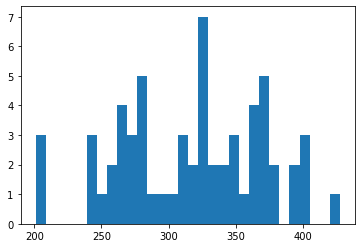

In [15]:
timespans = []
test_dir = ph.GetProcessedPath("Test")
dir_list = os.listdir(test_dir)
for filename in dir_list:
    filepath = os.path.join(test_dir, filename)
    _df = pd.read_csv(filepath)

    timespans.append(_df.loc[_df.shape[0]-1,"time_s"] - _df.loc[0,"time_s"])

print("min: {}".format(min(timespans)))
print("max: {}".format(max(timespans)))
print("avg: {}".format(np.mean(timespans)))

plt.hist(timespans, 30)

In [16]:
bellow_200 = []
for timespan in timespans:
    if timespan < 200:
        bellow_200.append(timespan)

len(bellow_200)

0

### Make Predictions

In [17]:
def PlotManyPredictions(filelist, r: int = 2):
    fig = plt.figure(constrained_layout=True)

    label_count = len(G_PARAMS.SEQUENTIAL_LABELS)
    rows = r
    cols = 4

    gs = fig.add_gridspec(rows*label_count, cols)

    i = 0
    for j in range(cols):
        for i in range(rows):
            flightname = filelist[i*cols + j]
            denormed_time, prediction_dict = Predict(
                                                filename=flightname,
                                                model=model,
                                                window=pred_window,
                                                NORM_PARAM=NORM_PARAM
                                            )

            # Plot every labels for one flight
            for sr in range(label_count):
                label_index = sr
                label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

                denormed_label, denormed_pred = prediction_dict[label]

                ax = fig.add_subplot(gs[i*label_count + sr, j])
                ax.plot (denormed_time, denormed_label)
                ax.plot (denormed_time, denormed_pred)
                ax.grid()

                if label_index == 0:
                    ax.set_title(flightname)
                if label_index == label_count-1:
                    ax.set_xlabel("Time (s)")

                if j == 0 or j == 2:
                    ax.set_ylabel('\n'*j + label)
                if j == 1 or j == 3:
                    ax.legend(["real", "prediction"])

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Prediction Samples\n")
    fig.show()

/tmp/ipykernel_97467/4053967539.py:48: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


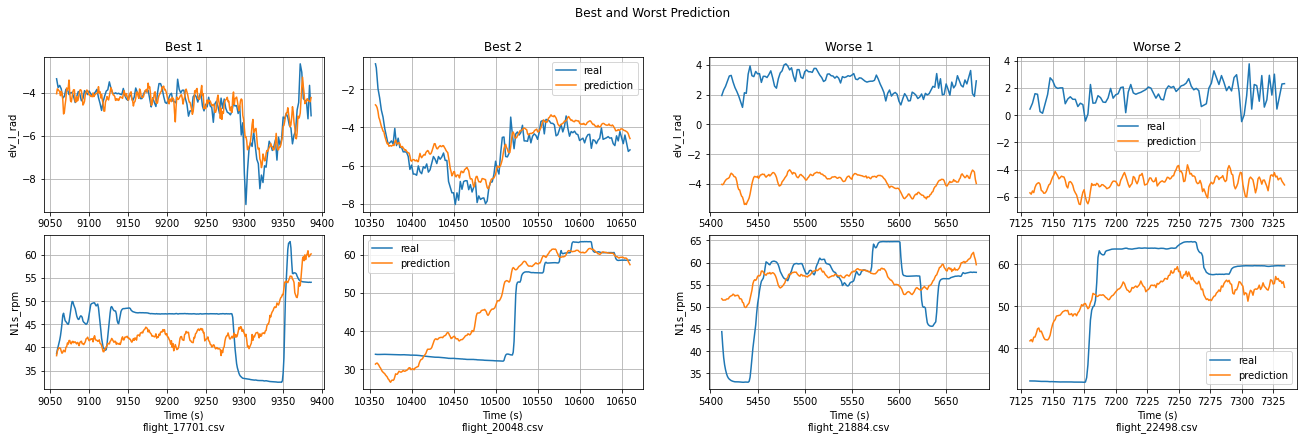

In [18]:
def plot_best_and_worst(metric_label = ["r2_elv_l_rad"]):
    best_list = list(r2_df.nlargest(10, columns=metric_label).iloc[:2, 0])
    worst_list = list(r2_df.nsmallest(10, columns=metric_label).iloc[:2, 0])
    flight_list = best_list + worst_list

    important_title = ["Best 1", "Best 2", "Worse 1", "Worse 2"]

    fig = plt.figure(constrained_layout=True)

    rows = len(G_PARAMS.SEQUENTIAL_LABELS)
    cols = 4

    gs = fig.add_gridspec(rows, cols)

    for j in range(cols):
        big_title = important_title[j]
        flightname = flight_list[j]
        denormed_time, prediction_dict = Predict(
                                            filename=flightname,
                                            model=model,
                                            window=pred_window,
                                            NORM_PARAM=NORM_PARAM
                                        )
        
        for i in range(rows):
            label_index = i % rows
            label = G_PARAMS.SEQUENTIAL_LABELS[label_index]

            denormed_label, denormed_pred = prediction_dict[label]

            ax = fig.add_subplot(gs[i, j])
            ax.plot (denormed_time, denormed_label)
            ax.plot (denormed_time, denormed_pred)
            ax.grid()

            if label_index == 0:
                ax.set_title(big_title)
            if label_index == rows-1:
                ax.set_xlabel("Time (s)" + "\n" + flightname)

            if j == 0 or j == 2:
                ax.set_ylabel('\n'*j + label)
            if j == 1 or j == 3:
                ax.legend(["real", "prediction"])

    fig.set_size_inches(18/4*cols, 3*rows)
    fig.suptitle("Best and Worst Prediction\n")
    fig.show()


metric_label = ["r2_elv_l_rad"]
plot_best_and_worst(metric_label)

In [19]:
row = 4
col = 4

n = row*col
filelist = list(r2_df.sample(n).iloc[:, 0])

PlotManyPredictions(filelist, r=row)

/tmp/ipykernel_97467/4126840474.py:45: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()
